# 特征工程

In [1]:
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import numpy as np
import random as rn
from tqdm import tqdm, tqdm_notebook
from gensim.models import Word2Vec
from gensim.models import FastText
import logging
import Levenshtein
import gc
import matplotlib as plt

In [2]:
np.random.seed(1017)
rn.seed(1017)
tqdm.pandas()

train = pd.read_table('train.txt', header = None, names = ['query', 'title','label'])

train['query'] = train['query'].apply(lambda x: x.split())
train['title'] = train['title'].apply(lambda x: x.split())

D:\anaconda\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
train.head()

,query,title,label
0,"[1573, 1730, 8392, 0, 689, 7, 2702]","[96, 1573, 1730, 8392]",1
1,"[4076, 1223, 3956, 8784, 1323]","[4076, 8784, 1323, 1223, 3956]",1
2,"[1035, 2149, 6205, 270, 2646, 1882, 2689]","[3333, 3009, 17, 1035, 2149, 6205, 270]",0
3,"[1039, 31, 0, 12870, 1743, 2517, 57, 260]","[1039, 31, 0, 12870, 177, 1743, 2517, 260]",1
4,"[3500, 1076, 3865, 22, 3392, 16096, 5084]","[3500, 1076, 3865, 2316, 3392, 225]",0


## 构造特征集 f1

In [3]:
def get_union_data(row):
    title_list = row['title']
    query_list = row['query']
    return len(list(set(title_list).intersection(set(query_list))))

def same_1(row):
    title_list = row['title']
    query_list = row['query']
    if title_list[0] ==  query_list[0]:
        return 1
    else:
        return 0

def same_2(row):
    title_list = row['title']
    query_list = row['query']
    if ' '.join(title_list[:2]) ==  ' '.join(query_list[:2]):
        return 1
    else:
        return 0

def same_3(row):
    title_list = row['title']
    query_list = row['query']
    if ' '.join(title_list[:3]) ==  ' '.join(query_list[:3]):
        return 1
    else:
        return 0

def is_all_in(row):
    if ' '. join(row['query']) in ' '.join(row['title']):
        return 1
    else:
        return 0

In [4]:
feature = pd.DataFrame()
feature['问题长度'] = train['query'].progress_apply(lambda row:len(row))
feature['标题长度'] = train['title'].progress_apply(lambda row:len(row))
feature['标题长度-问题长度'] = feature['标题长度'] - feature['问题长度']
feature['问题是否全部在标题里面'] = train.progress_apply(lambda row:is_all_in(row), axis=1)
feature['标题和问题的交集个数'] = train.progress_apply(lambda row:get_union_data(row), axis=1)
feature['标题问题词语的交集个数/问题长度'] = np.around(np.divide(feature['标题和问题的交集个数'], feature['问题长度']), 8)
feature['标题问题词语的交集个数/标题长度'] = np.around(np.divide(feature['标题和问题的交集个数'], feature['标题长度']), 8)
feature['编辑距离'] = train.progress_apply(lambda row:Levenshtein.distance(' '.join(row['query']), ' '.join(row['title'])), axis=1)
feature['前一个词语是否相同'] = train.progress_apply(lambda row:same_1(row), axis=1)
feature['前两个词语是否相同'] = train.progress_apply(lambda row:same_2(row), axis=1)
feature['前三个词语是否相同'] = train.progress_apply(lambda row:same_3(row), axis=1)

100%|███████████████████████████████████████████████████████████████████████| 248000/248000 [00:06<00:00, 37294.62it/s]


In [15]:
feature.head()

,问题长度,标题长度,标题长度-问题长度,问题是否全部在标题里面,标题和问题的交集个数,标题问题词语的交集个数/问题长度,标题问题词语的交集个数/标题长度,编辑距离,前一个词语是否相同,前两个词语是否相同,前三个词语是否相同
0,7,4,-3,0,3,0.428571,0.750000,16,0,0,0
1,5,5,0,0,5,1.000000,1.000000,16,1,0,0
2,7,7,0,0,4,0.571429,0.571429,23,0,0,0
3,8,8,0,0,7,0.875000,0.875000,7,1,1,1
4,7,6,-1,0,4,0.571429,0.666667,12,1,1,1


In [5]:
feature.to_csv('f1.csv', index=False)

## 构造特征集f2

In [6]:
def pos_1(row):
    title_list = row['title']
    query_list = row['query']
    value = -1
    try:
        value = title_list.index(query_list[0])
    except Exception:
        value = -1
    return value

def pos_2(row):
    title_list = row['title']
    query_list = row['query']
    if len(query_list) <=1 :
        return -1
    try:
        value = title_list.index(query_list[1])
    except Exception:
        value = -1
    return value

def pos_3(row):
    title_list = row['title']
    query_list = row['query']
    if len(query_list) <=2 :
        return -1
    try:
        value = title_list.index(query_list[2])
    except Exception:
        value = -1
    return value


In [7]:
feature = pd.DataFrame()
feature['第一个词语在标题里面出现位置'] = train.progress_apply(lambda row:pos_1(row), axis=1)
feature['第二个词语在标题里面出现位置'] = train.progress_apply(lambda row:pos_2(row), axis=1)
feature['第三个词语在标题里面出现位置'] = train.progress_apply(lambda row:pos_3(row), axis=1)
feature.to_csv('f2.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████| 248000/248000 [00:06<00:00, 35691.16it/s]


## 构造特征集f3

In [10]:
feature = pd.DataFrame()
train['title_str'] = train['title'].apply(lambda row: ' '.join(row))
train['query_str'] = train['query'].apply(lambda row: ' '.join(row))
feature['标题求组合后词语'] = train.groupby('title_str').query_str.transform('nunique')
feature['词语求组合后标题'] = train.groupby('query_str').title.transform('nunique')
feature.to_csv('f3.csv', index=False)

## 构造特征集f4

In [18]:
#fasttext本身相似度
feature = pd.DataFrame()
w2v = FastText.load('pretraining/fastText1.model')
def get_new_w2v(seq1, seq2):
    seq1 = seq1
    seq2 = seq2
    try:
        return w2v.n_similarity(seq1, seq2)
    except:
        return -1

f3 = pd.read_csv('f3.csv')
f3['fastText余弦相似度'] = train.progress_apply(lambda row:get_new_w2v(row['query'], row['title']), axis=1)
f3.to_csv('f3.csv', index=False)

w2v = Word2Vec.load('pretraining/word2vec.model')
def get_new_w2v(seq1, seq2):
    seq1 = seq1
    seq2 = seq2
    try:
        return w2v.n_similarity(seq1, seq2)
    except:
        return -1

f3 = pd.read_csv('f3.csv')
f3['w2v余弦相似度'] = train.progress_apply(lambda row:get_new_w2v(row['query'], row['title']), axis=1)
f3.to_csv('f3.csv', index=False)

  0%|                                                                             | 1/248000 [00:00<6:58:18,  9.88it/s]D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  
100%|████████████████████████████████████████████████████████████████████████| 248000/248000 [00:26<00:00, 9479.92it/s]


In [34]:
f3.head()

,标题求组合后词语,词语求组合后标题,fastText余弦相似度,w2v余弦相似度,w2v本身相似度
0,1,1,0.318293,0.685204,0.685204
1,4,2,1.000000,1.000000,1.000000
2,2,2,0.751652,0.739746,0.739746
3,1,1,0.972035,0.973235,0.973235
4,2,2,0.760532,0.721839,0.721839


In [32]:
w2v = Word2Vec.load('pretraining/word2vec.model')
def get_new_w2v(seq1, seq2):
    try:
        return w2v.n_similarity(seq1, seq2)
    except:
        return -1
f3['w2v本身相似度'] = train.progress_apply(lambda row:get_new_w2v(row['query'], row['title']), axis=1)


  0%|                                                                             | 1/248000 [00:00<7:08:42,  9.64it/s]D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  after removing the cwd from sys.path.

 49%|███████████████████████████████████▎                                    | 121471/248000 [00:13<00:15, 8136.12it/s]


 99%|███████████████████████████████████████████████████████████████████████▍| 246028/248000 [00:27<00:00, 8971.40it/s]


100%|████████████████████████████████████████████████████████████████████████| 248000/248000 [00:27<00:00, 8971.58it/s]


In [35]:
f1 = pd.read_csv('f1.csv')
f2 = pd.read_csv('f2.csv')
f3 = pd.read_csv('f3.csv')
feature = pd.concat([f1, f2, f3], sort=False, axis=1)
del f1, f2, f3
gc.collect()
feature.to_csv('features.csv', index=False)

In [36]:
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248000 entries, 0 to 247999
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   问题长度              248000 non-null  int64  
 1   标题长度              248000 non-null  int64  
 2   标题长度-问题长度         248000 non-null  int64  
 3   问题是否全部在标题里面       248000 non-null  int64  
 4   标题和问题的交集个数        248000 non-null  int64  
 5   标题问题词语的交集个数/问题长度  248000 non-null  float64
 6   标题问题词语的交集个数/标题长度  248000 non-null  float64
 7   编辑距离              248000 non-null  int64  
 8   前一个词语是否相同         248000 non-null  int64  
 9   前两个词语是否相同         248000 non-null  int64  
 10  前三个词语是否相同         248000 non-null  int64  
 11  第一个词语在标题里面出现位置    248000 non-null  int64  
 12  第二个词语在标题里面出现位置    248000 non-null  int64  
 13  第三个词语在标题里面出现位置    248000 non-null  int64  
 14  标题求组合后词语          248000 non-null  int64  
 15  词语求组合后标题          248000 non-null  int64  
 16  fastText余弦相似度     24

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000004E54ECBA8>,
      dtype=object)

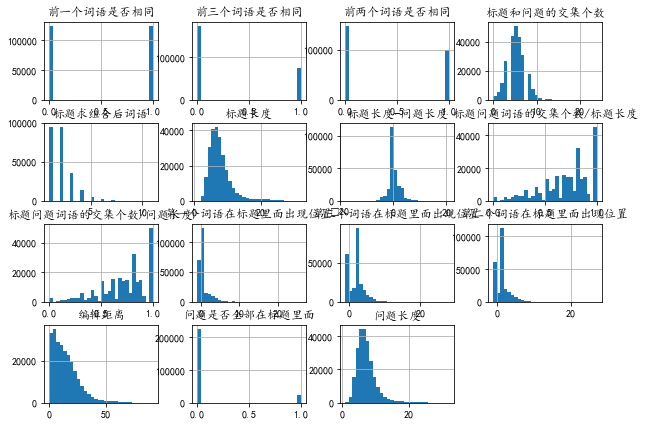

In [21]:
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.serif'] = ['KaiTi']
float_var = []
for i in list(feature.columns):
    float_var.append(i)
## figure3__异常值处理前数值变量的直方图
feature[float_var].hist(bins=30, figsize=(10,7))

In [25]:
feature.corr()

,问题长度,标题长度,标题长度-问题长度,问题是否全部在标题里面,标题和问题的交集个数,标题问题词语的交集个数/问题长度,标题问题词语的交集个数/标题长度,编辑距离,前一个词语是否相同,前两个词语是否相同,前三个词语是否相同,第一个词语在标题里面出现位置,第二个词语在标题里面出现位置,第三个词语在标题里面出现位置,标题求组合后词语
问题长度,1.000000,0.763765,-0.174790,-0.144435,0.533752,-0.311542,-0.137691,0.550587,-0.061884,-0.022255,0.020282,0.028030,0.037616,0.060056,-0.010692
标题长度,0.763765,1.000000,0.502059,-0.100176,0.430688,-0.213183,-0.419846,0.673004,-0.109295,-0.070192,-0.025254,0.134007,0.161249,0.188291,0.021120
标题长度-问题长度,-0.174790,0.502059,1.000000,0.040711,-0.058171,0.092225,-0.455934,0.288891,-0.083801,-0.077250,-0.065695,0.166853,0.195564,0.206747,0.046540
问题是否全部在标题里面,-0.144435,-0.100176,0.040711,1.000000,0.136621,0.373025,0.269506,-0.323664,0.220828,0.284757,0.373624,-0.022009,0.012291,0.070674,-0.037182
标题和问题的交集个数,0.533752,0.430688,-0.058171,0.136621,1.000000,0.564653,0.552442,-0.122355,0.253028,0.292776,0.329598,0.140651,0.206247,0.270579,-0.153517
标题问题词语的交集个数/问题长度,-0.311542,-0.213183,0.092225,0.373025,0.564653,1.000000,0.773150,-0.602040,0.355637,0.362108,0.357162,0.152637,0.234468,0.294570,-0.166103
标题问题词语的交集个数/标题长度,-0.137691,-0.419846,-0.455934,0.269506,0.552442,0.773150,1.000000,-0.650874,0.361137,0.367050,0.359630,0.030079,0.080773,0.114570,-0.163091
编辑距离,0.550587,0.673004,0.288891,-0.323664,-0.122355,-0.602040,-0.650874,1.000000,-0.451150,-0.434183,-0.404836,0.213268,0.167165,0.074050,0.095897
前一个词语是否相同,-0.061884,-0.109295,-0.083801,0.220828,0.253028,0.355637,0.361137,-0.451150,1.000000,0.826948,0.661163,-0.201625,-0.115007,0.009929,-0.075380
前两个词语是否相同,-0.022255,-0.070192,-0.077250,0.284757,0.292776,0.362108,0.367050,-0.434183,0.826948,1.000000,0.799522,-0.166733,-0.062954,0.005300,-0.079578


In [38]:
test = pd.read_table('test.txt', header = None, names = ['query', 'title'])

feature = pd.DataFrame()
feature['问题长度'] = test['query'].progress_apply(lambda row:len(row))
feature['标题长度'] = test['title'].progress_apply(lambda row:len(row))
feature['标题长度-问题长度'] = feature['标题长度'] - feature['问题长度']
feature['问题是否全部在标题里面'] = test.progress_apply(lambda row:is_all_in(row), axis=1)
feature['标题和问题的交集个数'] = test.progress_apply(lambda row:get_union_data(row), axis=1)
feature['标题问题词语的交集个数/问题长度'] = np.around(np.divide(feature['标题和问题的交集个数'], feature['问题长度']), 8)
feature['标题问题词语的交集个数/标题长度'] = np.around(np.divide(feature['标题和问题的交集个数'], feature['标题长度']), 8)
feature['编辑距离'] = test.progress_apply(lambda row:Levenshtein.distance(' '.join(row['query']), ' '.join(row['title'])), axis=1)
feature['前一个词语是否相同'] = test.progress_apply(lambda row:same_1(row), axis=1)
feature['前两个词语是否相同'] = test.progress_apply(lambda row:same_2(row), axis=1)
feature['前三个词语是否相同'] = test.progress_apply(lambda row:same_3(row), axis=1)


100%|████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 895713.53it/s]

100%|████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 783384.63it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 45675.18it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 40179.05it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 36224.07it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 38398.86it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 48265.65it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 47318.07it/s]


In [39]:

feature['第一个词语在标题里面出现位置'] = test.progress_apply(lambda row:pos_1(row), axis=1)
feature['第二个词语在标题里面出现位置'] = test.progress_apply(lambda row:pos_2(row), axis=1)
feature['第三个词语在标题里面出现位置'] = test.progress_apply(lambda row:pos_3(row), axis=1)


100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 48505.66it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 48632.09it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 48214.74it/s]


In [40]:
test['title_str'] = test['title'].apply(lambda row: ' '.join(row))
test['query_str'] = test['query'].apply(lambda row: ' '.join(row))
feature['标题求组合后词语'] = test.groupby('title_str').query_str.transform('nunique')
feature['词语求组合后标题'] = test.groupby('query_str').title.transform('nunique')

In [42]:
feature['fastText余弦相似度'] = test.progress_apply(lambda row:get_new_w2v(row['query'], row['title']), axis=1)
feature['w2v余弦相似度'] = test.progress_apply(lambda row:get_new_w2v(row['query'], row['title']), axis=1)
feature['w2v本身相似度'] = test.progress_apply(lambda row:get_new_w2v(row['query'], row['title']), axis=1)


  0%|                                                                                        | 0/12500 [00:00<?, ?it/s]D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  after removing the cwd from sys.path.

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 34612.52it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 32041.05it/s]

100%|█████████████████████████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 34763.49it/s]


In [37]:
w2v = pd.read_csv('feature_test.csv')
feature['w2v本身相似度']  = w2v['w2v本身相似度']
feature['fastText本身相似度']  = w2v['fastText本身相似度']

FileNotFoundError: [Errno 2] File feature_test.csv does not exist: 'feature_test.csv'

In [44]:
feature.head()
feature.to_csv('features_test.csv', index=False)